# Assignment 6 : Pretrain and Transfer Learning (20 pts)

### Before working on the assignment please read papers as following 
- SUPERVISED CONTRASTIVE LEARNING FOR PRE-TRAINED LANGUAGE MODEL FINE-TUNING
  - link: https://openreview.net/pdf?id=cu7IUiO
- Few-Shot Intent Detection via Contrastive Pre-Training and Fine-Tuning
  - link: https://arxiv.org/abs/2109.06349

# Question 5: Training on text classification task  on combine two losses Cross Entropy and Supervised Contrastive. (3.5 pts)

- Cross Entropy loss
$$
\mathcal{L}_\text{CE} =-\frac{1}{m} \sum_{i=1}^{m} yi \cdot log(\hat{yi})
$$

- Supervised Contrastive learning loss
$$
\mathcal{L}_\text{S_cl} = -\frac{1}{T}\sum_{i=1}^{N}\sum_{j=1}^{N} \boldsymbol{1_{yi=yj}}\enspace log \frac{e^{sim(hi,hj) / \tau}}{\sum_{n=1}^{N} e^{sim(hi,hn) / \tau}}
$$
     * detail 
       * ui ~ sentence i 
       * hi ~ BERT(ui) in our case using Roberta as a encoder
       * hi : (batch_size,sequence_len,embed_size)
       * hi is the output of model which is last hidden layers before classifier head in the model architecture
       * 1yi=yj ~ we select only the sample that come from the same class to compute in each i and j
       * T ~ the number of pairs that come from the same classes
       * $\tau$ ~ temperature parameter
       * Sim(x1,x2) : cosine similarity [-1, 1]
       - $\lambda'$ is just weighted of cross entropy loss 
       * Sim function is the cosine similarity 
       * N ~ the number of samples in a batch
$$
sim(A,B) = \cos{(\theta)} = \frac{A\cdot B}{|\!|A|\!||\!|B|\!|}
$$


- Loss total
$$
  \mathcal{L}_\text{total} = \mathcal{L}_\text{s_cl} + \lambda ' \mathcal{L}_{CE}
$$

* you can get cross entropy loss like below 
    * outputs = model(input_ids, labels=labels)
    * loss, logits = outputs[:2]
    * loss : this is cross entropy loss
      
- hint : for this question you will utilize the function CustomTextDataset to force dataloader to have at least one pair that come from the same class
     * eg. batch_size = 4 
     * the labels in a batch should be like [ 0, 21, 43, 0]  
     
5. training this model in the code below on loss_total by do experiment the same as question 4.1, 4.2, 4.3, 4.4, 4.5, 4.6

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import random
from IPython.display import clear_output
from utils import create_supervised_pair, supervised_contrasive_loss, Similarity
import matplotlib.pyplot as plt
#comment this if you are not using puffer
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [31]:
def freeze_layers(model,freeze_layers_count:int=0):

        """
        model : model object that we create 
        freeze_layers_count : the number of layers to freeze 
        """
        # write the code here
    
        # should not more than the number of layers in a backbone
        assert freeze_layers_count <= 12  
        if freeze_layers_count <= 0:
            pass
        else:
            for name, param in model.named_parameters():
                # print(type(name))

                keys = name.split(".")

                if str(freeze_layers_count) in keys or 'classifier' in keys:
                    break

                param.requires_grad = False 


        #print all parameter that we want to train from scratch 
        
        for name, param in model.named_parameters():
            
            if param.requires_grad == True:
                 
                print(name)
        
    
        return model     

## To download data from file directory both text samples and labels

In [8]:
def load_examples(file_path, do_lower_case=True):
    examples = []
    
    with open('{}/seq.in'.format(file_path),'r',encoding="utf-8") as f_text, open('{}/label'.format(file_path),'r',encoding="utf-8") as f_label:
        for text, label in zip(f_text, f_label):
            
            e = Inputexample(text.strip(),label=label.strip())
            examples.append(e)
            
    return examples

## Each sample has a sentence and label format

In [9]:
class Inputexample(object):
    def __init__(self,text_a,label = None):
        self.text = text_a
        self.label = label

In [10]:
# create custom dataset class
# ===  =  Hint =  ===
# can train on two condition 
# 1.) trainig training with supervise contrastive loss and cross entropy loss using in question 5.) 
#    when self.repeated_label == True:
# 2.) train only cross entropy loss use in question 4.)
#    when self.repeated_label == False:

class CustomTextDataset(Dataset):
    def __init__(self,labels,text,batch_size,repeated_label:bool=False):
        self.labels = labels
        self.text = text
        self.batch_size = batch_size 
        self.count = 0 
        self.batch_labels = []
        self.repeated_label = repeated_label
        
        if self.repeated_label == True:
            print("Train on Combine between Supervised Contrastive and Cross Entropy loss")
            
        else:
            print("Train on Cross Entropy loss")
            
        
        print("len of dataset :",len(self.labels))
              
     
          

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        
        
        # write code here for 1)
        if self.repeated_label == True:
        
            if len(np.unique(self.batch_labels)) == self.batch_size - 1:


                while True:
                    idx = np.random.choice(len(self.labels))

                    if self.labels[idx]  in self.batch_labels:

                       
                        break

        self.batch_labels.append(self.labels[idx])
        
        label = self.labels[idx]
        
        data = self.text[idx]
        
        sample = {"Class": label,"Text": data}


    
        return sample

### Train With Combine loss between Cross Entropy and SuperVised Contrastive loss 

In [11]:
def train_contrastive_learnig(model,optimizer,train_loader,tokenizer,valid_loader,device,epochs:int=30):
    
    
    train_loss_hist = [] 
    valid_loss_hist = []
    
    train_acc_hist = []
    valid_acc_hist = []
    

    test_acc = []

    min_valid_loss = np.inf
    
    for e in range(epochs):  # loop over the dataset multiple times
 
        model.train()
        correct = 0
        running_loss = 0.0
       

        for (idx, batch) in enumerate(train_loader):
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")


            #assert len(np.unique(batch["Class"])) < len(batch["Class"])  
            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)


             # clear gradients
            optimizer.zero_grad()
            
            
            outputs = model(**inputs,labels=labels,output_hidden_states=True)     
        
            hidden_states = outputs.hidden_states

            last_hidden_states = hidden_states[12]

            # https://stackoverflow.com/questions/63040954/how-to-extract-and-use-bert-encodings-of-sentences-for-text-similarity-among-sen 
            # (batch_size,seq_len,embed_dim)
            h = last_hidden_states[:,0,:]

            # create pair samples
            T, h_i, h_j, idx_yij = create_supervised_pair(h,batch['Class'],debug=False)

            if h_i is None:
                print("skip this batch")
                skip_time +=1
                continue

            # supervised contrastive loss 
            
            loss_s_cl = supervised_contrasive_loss(device,h_i, h_j, h, T,temp=temp,idx_yij=idx_yij,debug=False)

            # cross entropy loss
            loss_classify, logits = outputs[:2]

            # loss total
            loss = loss_s_cl + (lamda * loss_classify )

            # Calculate gradients
            loss.backward()

            # Update Weights
            optimizer.step()

            # Calculate Loss
            running_loss += loss.item()
            
            #calculate nums of correction 
            correct += (torch.max(logits,dim=-1)[1] == labels).sum()

        
        train_loss_hist.append(running_loss/len(train_data))
        train_acc_hist.append(correct/len(train_data))
        
        
        print(f'======  Epoch {e+1} ====== ')
        print(f' Training Loss: {running_loss/len(train_data)}, \t\t Training acc: {correct/len(train_data)}')
        
        print("train correct : ",correct)
        print("train total :",len(train_data))
        
        
        running_loss = 0.0
        correct = 0
        model.eval()     # Optional when not using Model Specific layer
        log_correct = []
        
        
        for (idx, batch) in enumerate(valid_loader):
            
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")


            #assert len(np.unique(batch["Class"])) < len(batch["Class"])  
            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)


             # clear gradients
            optimizer.zero_grad()
            
            
            outputs = model(**inputs,labels=labels,output_hidden_states=True)     
        
            hidden_states = outputs.hidden_states

            last_hidden_states = hidden_states[12]

            # https://stackoverflow.com/questions/63040954/how-to-extract-and-use-bert-encodings-of-sentences-for-text-similarity-among-sen 
            # (batch_size,seq_len,embed_dim)
            h = last_hidden_states[:,0,:]

            # create pair samples
            T, h_i, h_j, idx_yij = create_supervised_pair(h,batch['Class'],debug=False)

            if h_i is None:
                print("skip this batch")
                skip_time +=1
                continue

            # supervised contrastive loss 
            loss_s_cl = supervised_contrasive_loss(device,h_i, h_j, h, T,temp=temp,idx_yij=idx_yij,debug=False)

            # cross entropy loss
            loss_classify, logits = outputs[:2]

            # loss total
            loss = loss_s_cl + (lamda * loss_classify )
            
            # Calculate Loss
            running_loss += loss.item()
            
            #calculate nums of correction 
            correct += (torch.max(logits,dim=-1)[1] == labels).sum()
            
        # 5.3 add code to collect loss 
        valid_loss_hist.append(running_loss/len(valid_data))
        valid_acc_hist.append(correct/len(valid_data))
        
        print(f' Validation Loss: {running_loss/len(valid_data)}, \t\t Validation acc: {correct/len(valid_data)}')
        
        print("valid correct : ",correct)
        print("valid total :",len(valid_data))
       
        
        
        # save best current model 
        if min_valid_loss > (running_loss/len(valid_data)):
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{running_loss/len(valid_data):.6f}) \t Saving The Model')
            min_valid_loss = running_loss/len(valid_data) 
            # torch.save(model.state_dict(), 'saved_model.pth')
            
       
            
    return (train_acc_hist, train_loss_hist), (valid_acc_hist, valid_loss_hist)  

### Test function

In [12]:
#  no gradients needed
def test(model,test_loader,data_size):
    
    correct = 0
         
    with torch.no_grad():
        for (idx, batch) in enumerate(test_loader):
            sentence = batch["Text"]
            inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")

            # move parameter to device
            inputs = {k:v.to(device) for k,v in inputs.items()}

            # map string labels to class idex
            labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

            # convert list to tensor
            labels = torch.tensor(labels).unsqueeze(0)
            labels = labels.to(device)
            
            # Foward pass 
            outputs = model(**inputs,labels=labels)

            # get loss and output 
            loss, logits = outputs[:2]
            
            _, predicted = torch.max(logits, -1)
            
            
           
         
            correct += (predicted == labels).sum().item()
            
    print("correct :",correct)
    print("total :",data_size)
         
    return correct / data_size

## Define Parameters

In [23]:
N = 5
data = []
labels = []

train_samples = []
train_labels = []

valid_samples = []
valid_labels = []

test_samples = []
test_labels = []

embed_dim = 768
batch_size = 4 
lr=2e-3   # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### The Aim of these training is to fine tuning on few shot setting on text classification task

Path example of train, validation and test 

In [24]:
path_5shot = f'./HWU64/train_5/'
valid_path = f'./HWU64/valid/'
test_path = f'./HWU64/test/'

In [25]:
# Download data fewshot 
# https://downgit.github.io/#/home?url=https:%2F%2Fgithub.com%2Fjianguoz%2FFew-Shot-Intent-Detection%2Ftree%2Fmain%2FDatasets%2FHWU64

# load data
train_samples = load_examples(path_5shot)
valid_samples = load_examples(valid_path)
test_samples = load_examples(test_path)


print("===== small train set ====")

for i in range(len(train_samples)):
    data.append(train_samples[i].text)
    labels.append(train_samples[i].label)


train_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=True)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)



print("===== validation set ====")

data = []
labels = []

for i in range(len(valid_samples)):
    data.append(valid_samples[i].text)
    labels.append(valid_samples[i].label)

valid_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=True)
valid_loader = DataLoader(valid_data,batch_size=batch_size,shuffle=True)


print("===== test set ====")

data = []
labels = []
    
for i in range(len(test_samples)):
    data.append(test_samples[i].text)
    labels.append(test_samples[i].label)

test_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=True)



# got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels)))

# get text label of uniqure classes
unique_label = np.unique(np.array(labels))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

===== small train set ====
Train on Combine between Supervised Contrastive and Cross Entropy loss
len of dataset : 320
===== validation set ====
Train on Combine between Supervised Contrastive and Cross Entropy loss
len of dataset : 1076
===== test set ====
Train on Combine between Supervised Contrastive and Cross Entropy loss
len of dataset : 1076


In [26]:
# Download tokenizer that use to tokenize sentence into words by using Pretrain from roberta-base
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

### 5.1  freeze weight from pretrain model all layer except classifier 

Download Pretrain Model

In [27]:
!nvidia-smi

Sun Apr  3 17:13:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:84:00.0 Off |                  N/A |
| 47%   78C    P2   246W / 250W |   8389MiB / 11264MiB |     34%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:85:00.0 Off |                  N/A |
| 37%   

In [22]:
device

device(type='cuda', index=1)

In [28]:
# download config of Roberta config 
config = RobertaConfig.from_pretrained("roberta-base",output_hidden_states=True)

#chnage modifying the number of classes
config.num_labels = num_class
# Download pretrain models weight 
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
# change from binary classification to muli-classification and loss automatically change to cross entropy loss
model.num_labels = config.num_labels
# change the output of last layer to num_class that we want to predict
model.classifier.out_proj = nn.Linear(in_features=embed_dim,out_features=num_class)
# move to model to device that we set
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [32]:
## Fine-Tune  model on SuperVised Contrastive loss 
# 5.1 freeze weight from pretrain model all layer except classifier 
model = freeze_layers(model,freeze_layers_count=9)
# Using adam optimizer 
optimizer= AdamW(model.parameters(), lr=lr)

roberta.encoder.layer.9.attention.self.query.weight
roberta.encoder.layer.9.attention.self.query.bias
roberta.encoder.layer.9.attention.self.key.weight
roberta.encoder.layer.9.attention.self.key.bias
roberta.encoder.layer.9.attention.self.value.weight
roberta.encoder.layer.9.attention.self.value.bias
roberta.encoder.layer.9.attention.output.dense.weight
roberta.encoder.layer.9.attention.output.dense.bias
roberta.encoder.layer.9.attention.output.LayerNorm.weight
roberta.encoder.layer.9.attention.output.LayerNorm.bias
roberta.encoder.layer.9.intermediate.dense.weight
roberta.encoder.layer.9.intermediate.dense.bias
roberta.encoder.layer.9.output.dense.weight
roberta.encoder.layer.9.output.dense.bias
roberta.encoder.layer.9.output.LayerNorm.weight
roberta.encoder.layer.9.output.LayerNorm.bias
roberta.encoder.layer.10.attention.self.query.weight
roberta.encoder.layer.10.attention.self.query.bias
roberta.encoder.layer.10.attention.self.key.weight
roberta.encoder.layer.10.attention.self.key.b

In [33]:
train_log, valid_log = train_contrastive_learnig(model,optimizer,train_loader,tokenizer,valid_loader,device,epochs=30)

======  Epoch 1 ====== 
 Training Loss: 0.3599725116044283, 		 Training acc: 0.390625
train correct :  tensor(125, device='cuda:0')
train total : 320
 Validation Loss: 0.39146619093462437, 		 Validation acc: 0.0
valid correct :  tensor(0, device='cuda:0')
valid total : 1076
Validation Loss Decreased(inf--->0.391466) 	 Saving The Model
======  Epoch 2 ====== 
 Training Loss: 0.35133991204202175, 		 Training acc: 0.3499999940395355
train correct :  tensor(112, device='cuda:0')
train total : 320
 Validation Loss: 0.3954591830866931, 		 Validation acc: 0.0
valid correct :  tensor(0, device='cuda:0')
valid total : 1076
======  Epoch 3 ====== 
 Training Loss: 0.35608390271663665, 		 Training acc: 0.328125
train correct :  tensor(105, device='cuda:0')
train total : 320
 Validation Loss: 0.39195900424262403, 		 Validation acc: 0.0
valid correct :  tensor(0, device='cuda:0')
valid total : 1076
======  Epoch 4 ====== 
 Training Loss: 0.3521488424390554, 		 Training acc: 0.359375
train correct : 

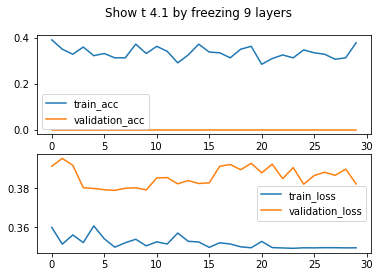

In [39]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Show t 4.1 by freezing 9 layers')
ax1.plot(torch.tensor(train_log[0] , device = 'cpu').tolist())
ax1.plot(torch.tensor(valid_log[0] , device = 'cpu').tolist())
ax1.legend(['train_acc','validation_acc'])
ax2.plot(torch.tensor(train_log[1] , device = 'cpu').tolist())
ax2.plot(torch.tensor(valid_log[1] , device = 'cpu').tolist())
ax2.legend(['train_loss','validation_loss'])

In [46]:
test_acc = test(model,test_loader=test_loader,data_size=len(test_data))

correct : 0
total : 1076


In [47]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 0.0 %


### 5.2  freeze all from top embeddings to encoder layers (12)

Download Pretrain Model

In [41]:
# download config of Roberta config 
config = RobertaConfig.from_pretrained("roberta-base",output_hidden_states=True)

#chnage modifying the number of classes
config.num_labels = num_class
# Download pretrain models weight 
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
# change from binary classification to muli-classification and loss automatically change to cross entropy loss
model.num_labels = config.num_labels
# change the output of last layer to num_class that we want to predict
model.classifier.out_proj = nn.Linear(in_features=embed_dim,out_features=num_class)
# move to model to device that we set
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [42]:
## Fine-Tune  model on SuperVised Contrastive loss 
# 5.1 freeze weight from pretrain model all layer except classifier 
model = freeze_layers(model,freeze_layers_count=12)
# Using adam optimizer 
optimizer= AdamW(model.parameters(), lr=lr)

classifier.dense.weight
classifier.dense.bias
classifier.out_proj.weight
classifier.out_proj.bias


In [43]:
train_log, valid_log = train_contrastive_learnig(model,optimizer,train_loader,tokenizer,valid_loader,device,epochs=30)

======  Epoch 1 ====== 
 Training Loss: 0.36022028177976606, 		 Training acc: 0.6781250238418579
train correct :  tensor(217, device='cuda:0')
train total : 320
 Validation Loss: 0.37863524130729054, 		 Validation acc: 0.0
valid correct :  tensor(0, device='cuda:0')
valid total : 1076
Validation Loss Decreased(inf--->0.378635) 	 Saving The Model
======  Epoch 2 ====== 
 Training Loss: 0.35386207662522795, 		 Training acc: 0.9312500357627869
train correct :  tensor(298, device='cuda:0')
train total : 320
 Validation Loss: 0.37620613222671706, 		 Validation acc: 0.0
valid correct :  tensor(0, device='cuda:0')
valid total : 1076
Validation Loss Decreased(0.378635--->0.376206) 	 Saving The Model
======  Epoch 3 ====== 
 Training Loss: 0.3521142084151506, 		 Training acc: 0.9906250238418579
train correct :  tensor(317, device='cuda:0')
train total : 320
 Validation Loss: 0.37597361827428455, 		 Validation acc: 0.0
valid correct :  tensor(0, device='cuda:0')
valid total : 1076
Validation Los

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Show t 4.1 by freezing 12 layers')
ax1.plot(torch.tensor(train_log[0] , device = 'cpu').tolist())
ax1.plot(torch.tensor(valid_log[0] , device = 'cpu').tolist())
ax1.legend(['train_acc','validation_acc'])
ax2.plot(torch.tensor(train_log[1] , device = 'cpu').tolist())
ax2.plot(torch.tensor(valid_log[1] , device = 'cpu').tolist())
ax2.legend(['train_loss','validation_loss'])

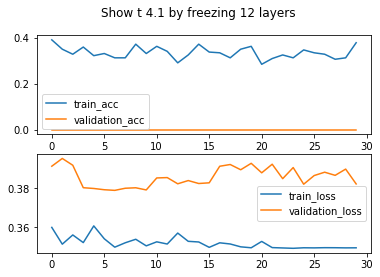

In [45]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Show t 4.1 by freezing 9 layers')
ax1.plot(torch.tensor(train_log[0] , device = 'cpu').tolist())
ax1.plot(torch.tensor(valid_log[0] , device = 'cpu').tolist())
ax1.legend(['train_acc','validation_acc'])
ax2.plot(torch.tensor(train_log[1] , device = 'cpu').tolist())
ax2.plot(torch.tensor(valid_log[1] , device = 'cpu').tolist())
ax2.legend(['train_loss','validation_loss'])

In [46]:
test_acc = test(model,test_loader=test_loader,data_size=len(test_data))

correct : 0
total : 1076


In [47]:
print(f'Accuracy : {100 * test_acc} %') 

Accuracy : 0.0 %
